# **Week 3 Miniproject**

***Step 1: Brief description of problem and data***

The primary goal of this project is to automate the identification of metastatic cancer in digital pathology images. This will be achieved by creating deep learning models capable of accurately classifying whether a given image patch contains evidence of cancer.The dataset used is a modified version of the PatchCamelyon (PCam) benchmark dataset, which is focused on detecting metastasis in cancer patients.

***Step 2: Exploratory Data Analysis (EDA)***

The dataset used for this project contains image patches extracted from whole-slide images of sections. The primary task is to classify each patch as either containing metastatic tissue (label 1) or not (label 0). The collection is made of small pathology images for classification, each identified by a unique image ID. The truth labels for the images in the train folder are provided in the train_labels.csv file. A positive label indicates that the central 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not affect the label. This outer region is included to allow for fully-convolutional models that avoid zero-padding, ensuring consistent behavior when applied to whole-slide images. The final task is to predict labels for the images in the test folder. We will load the libraries and explore de data. 

In [1]:
# Load libraries and data

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import shutil
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperParameters
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import load_model





2024-06-18 21:50:51.941404: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 21:50:51.941543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 21:50:52.115043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


To understand the dataset, we performed the following EDA steps:

Data Visualization
1. Label Distribution: Visualized the distribution of labels to check for class imbalance: A histogram of the total count of samples for cancerous and healthy tissue.
2. Sample Images: Displayed a few sample images from each class to understand the visual differences between healthy and cancerous tissues.

Dataset contains 220025 images with 2 columns.


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


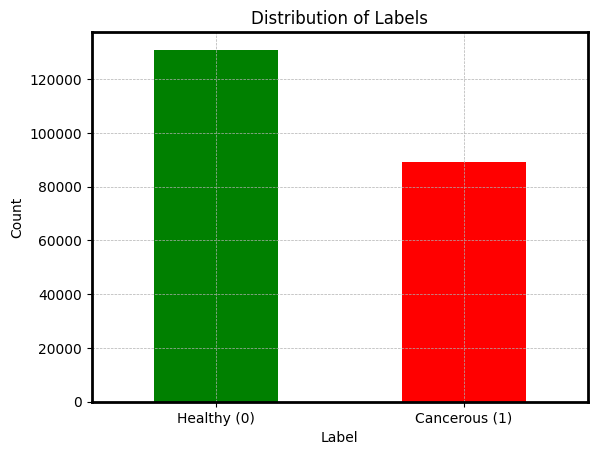

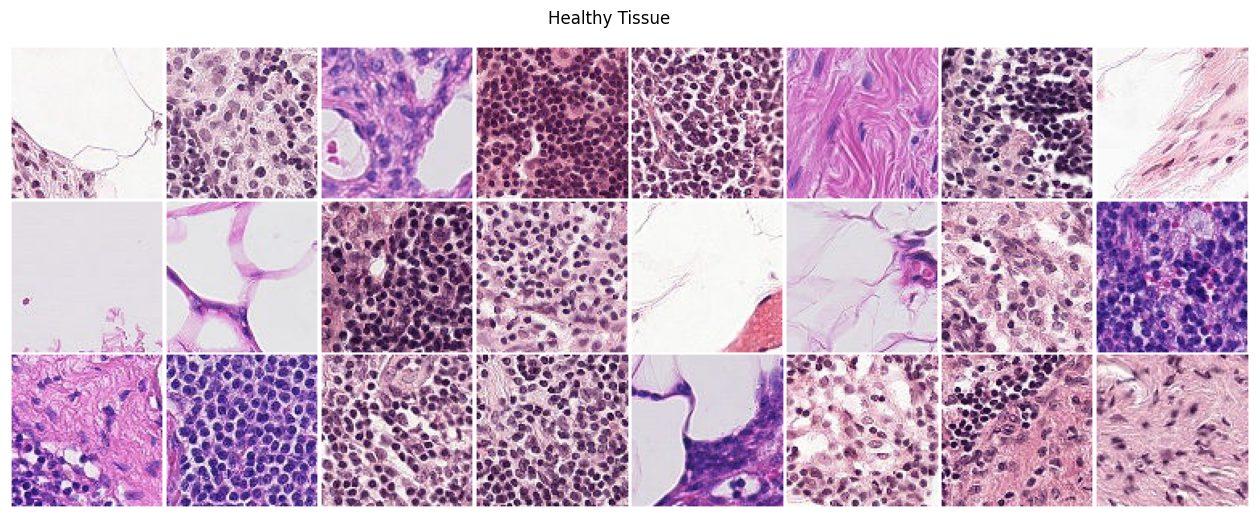

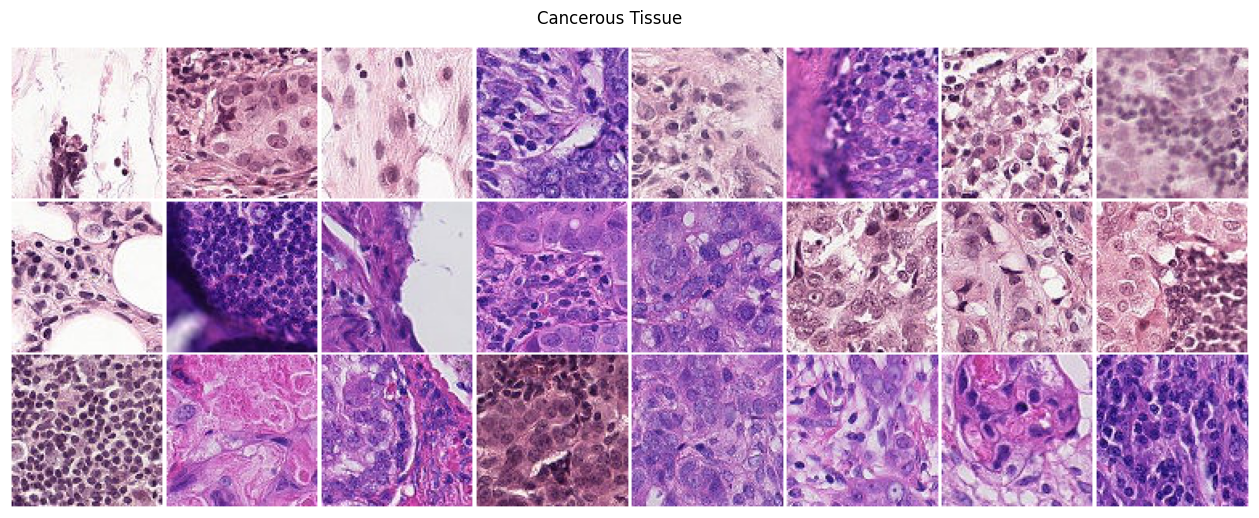

In [2]:
#2 Exploratory Data Analysis
# Display data and plot distribution of labels (Healthy:0, Cancerous:1)

# Import data
train_labels_df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
print(f"Dataset contains {train_labels_df.shape[0]} images with {train_labels_df.shape[1]} columns.")
display(train_labels_df)

# Plot the distribution of labels with a border, grid, and legend
ax = train_labels_df['label'].value_counts().plot(kind='bar', color=['green', 'red'])
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Healthy (0)', 'Cancerous (1)'])
ax.set_title('Distribution of Labels')

# Add a border to the plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

# Add a grid to the plot
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.xticks(rotation=0)
plt.show()

# Tissue sample

# Healthy tissue image labels
healthy_labels = train_labels_df[train_labels_df['label'] == 0]['id'].values

# Cancerous tissue image labels
cancerous_labels = train_labels_df[train_labels_df['label'] == 1]['id'].values

# Function to plot images
def display_images(image_ids, plot_title, rows=3, cols=8):
    fig, ax = plt.subplots(rows, cols, figsize=(16, 6))
    plt.subplots_adjust(wspace=0, hspace=0) 

    for idx, img_id in enumerate(image_ids[:rows * cols]):
        image_path = os.path.join('../input/histopathologic-cancer-detection/train/', img_id + '.tif')
        image = Image.open(image_path)
        draw = ImageDraw.Draw(image)
        draw.rectangle(((0, 0), (95, 95)), outline='white')
        ax[idx // cols, idx % cols].imshow(np.array(image))
        ax[idx // cols, idx % cols].axis('off')

    plt.suptitle(plot_title, y=0.94)
    plt.show()
    
# Plotting images
display_images(healthy_labels, "Healthy Tissue")
display_images(cancerous_labels, "Cancerous Tissue")

*Data Preprocessing*

In [3]:
#Creation of data set for trainting,testing and validation

# Load your dataset
train_labels_df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# Define the split ratios for the total amount of image (~220K)
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

# First, split the data into train and temp sets (temp will be split into validation and test sets)
train_data, temp_data, train_labels, temp_labels = train_test_split(
    train_labels_df['id'].values, train_labels_df['label'].values, test_size=(1 - train_ratio), random_state=42)

# Now split the temp data into validation and test sets
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=(test_ratio / (test_ratio + validation_ratio)), random_state=42)



In [4]:

#Data preparation for deep learning

# Reduce the dataset to a subset (e.g., 10% of the data)
FasterSubset = 5000  # Use a subset (fraction) for faster iterations. Takes a smaller somples from the train and validation pools
FasterSubset_train = train_ratio * FasterSubset
FasterSubset_val = validation_ratio * FasterSubset

#Resizing
IMG_WIDTH, IMG_HEIGHT = 96, 96

# Convert label column to string
train_labels_df['label'] = train_labels_df['label'].astype(str)

# Add the ".tif" extension to the 'id' column for correct file cross-referencing
train_labels_df['id'] = train_labels_df['id'].apply(lambda x: f"{x}.tif")

train_labels_df.head(10)

# Prepare data generators
#train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # normalize

train_datagen = ImageDataGenerator(
    rescale=1./255, # normalize,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

batch_size = 64  # Increased batch size for better GPU utilization

# Training images (FasterSubset_train)
train_steps = int(FasterSubset_train // batch_size)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_labels_df.head(FasterSubset), 
    directory='../input/histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='binary',
    batch_size=batch_size,
    subset='training')

# Validation images 
val_steps = int(FasterSubset_val // batch_size)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_labels_df.head(FasterSubset),
    directory='../input/histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='binary',
    batch_size=batch_size,
    subset='validation')

Found 4000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


***Step 3: Model Arquitecture***

*Model 1:* Basic CNN Architecture
Model 1 consists of three convolutional layers followed by max-pooling layers, and ends with a fully connected layer. Specifically, it includes Conv2D layers with 32, 64, and 128 filters respectively, each with a 3x3 kernel and ReLU activation. Each convolutional layer is followed by a MaxPooling2D layer with a 2x2 pool size. The network then has a Flatten layer, followed by a Dense layer with 512 units and ReLU activation, a Dropout layer with a rate of 0.5 to prevent overfitting, and a final Dense layer with 1 unit and Sigmoid activation for binary classification. This basic architecture was chosen because it provides a good starting point for image classification tasks, balancing complexity and computational efficiency, and serving as a baseline for comparing more complex architectures.

*Model 2:* Deeper CNN with More Filters and Additional Convolutional Layers
Model 2 extends the architecture of Model 1 by adding an additional convolutional layer and increasing the number of filters. It consists of four Conv2D layers with 32, 64, 128, and 256 filters respectively, each with a 3x3 kernel and ReLU activation, followed by MaxPooling2D layers with a 2x2 pool size. This deeper network is designed to capture more complex features and patterns in the data. The fully connected part of the model includes a Flatten layer, a Dense layer with 512 units and ReLU activation, a Dropout layer with a rate of 0.5, and a final Dense layer with 1 unit and Sigmoid activation. The rationale for this architecture is to improve the model's ability to learn from the data by adding more layers and filters, thereby enhancing feature extraction capabilities.

*Model 3:* CNN with Different Kernel Sizes and More Dropout
Model 3 modifies the architecture further by varying the kernel sizes and increasing the dropout rate to enhance regularization. It includes three Conv2D layers with 64, 128, and 256 filters respectively, where the first two layers use a 5x5 kernel and the third uses a 3x3 kernel, all with ReLU activation. Each convolutional layer is followed by a MaxPooling2D layer with a 2x2 pool size. The model then has a Flatten layer, a Dense layer with 512 units and ReLU activation, a Dropout layer with a rate of 0.6, and a final Dense layer with 1 unit and Sigmoid activation. This architecture was chosen to explore the effects of different kernel sizes on feature extraction and to improve generalization by using a higher dropout rate, aiming to reduce overfitting and improve the model's robustness.:

In [5]:
# 3. Model Architecture

# Define the models

# Model 1: Basic CNN Architecture

model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
    
model1.compile(optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])

model1.summary()

# Model 2: Deeper CNN with More Filters and Additional Convolutional Layers

model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
        
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
    ])
    
model2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model2.summary()

# Model 3: CNN with Different Kernel Sizes and More Dropout
model3 = Sequential([
    Conv2D(64, (5,5), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2,2),

    Conv2D(128, (5,5), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.6),  # Increased dropout rate
    Dense(1, activation='sigmoid')
    ])
    
model3.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,873 (25.36 MB)

 Trainable params: 6,647,873 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,486,593 (9.49 MB)

 Trainable params: 2,486,593 (9.49 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 92, 92, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 42, 42, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 19, 19, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,122,817 (42.43 MB)

 Trainable params: 11,122,817 (42.43 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Train the models
history1 = model1.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=10)

history2 = model2.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=10)

history3 = model3.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=10)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5503 - loss: 0.7956 - val_accuracy: 0.6760 - val_loss: 0.6293
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.6693 - loss: 0.6094 - val_accuracy: 0.7000 - val_loss: 0.6026
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 759ms/step - accuracy: 0.7133 - loss: 0.5591 - val_accuracy: 0.6281 - val_loss: 0.6109
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - accuracy: 0.7401 - loss: 0.5408 - val_accuracy: 0.8250 - val_loss: 0.4336
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 724ms/step - accuracy: 0.7816 - loss: 0.4792 - val_accuracy: 0.7594 - val_loss: 0.5165
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.7552 - loss: 0.5228 - val_accuracy: 0.8500 - val_loss: 0.3656
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 733ms/step - accuracy: 0.7704 - loss: 0.4968 - val_accuracy: 0.7708 - val_loss: 0.4961
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.7914 - loss: 0.4650 - val_accuracy:

In [7]:
# Save the first model
model1.save('model1.h5')
# Save the second model
model2.save('model2.h5')
# Save the third model
model3.save('model3.h5')

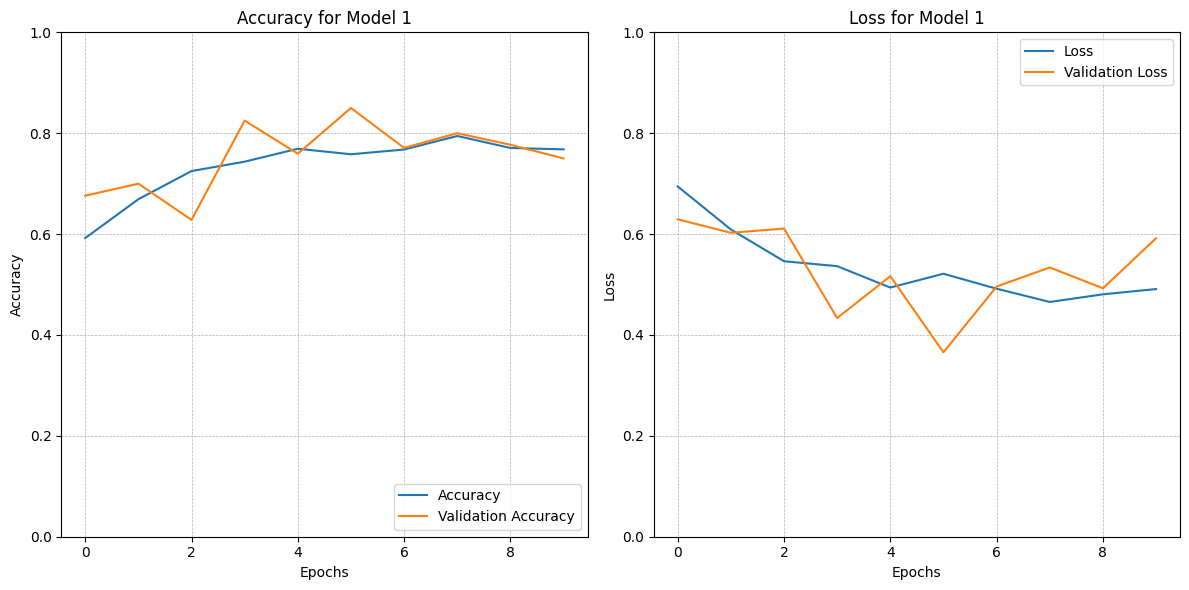

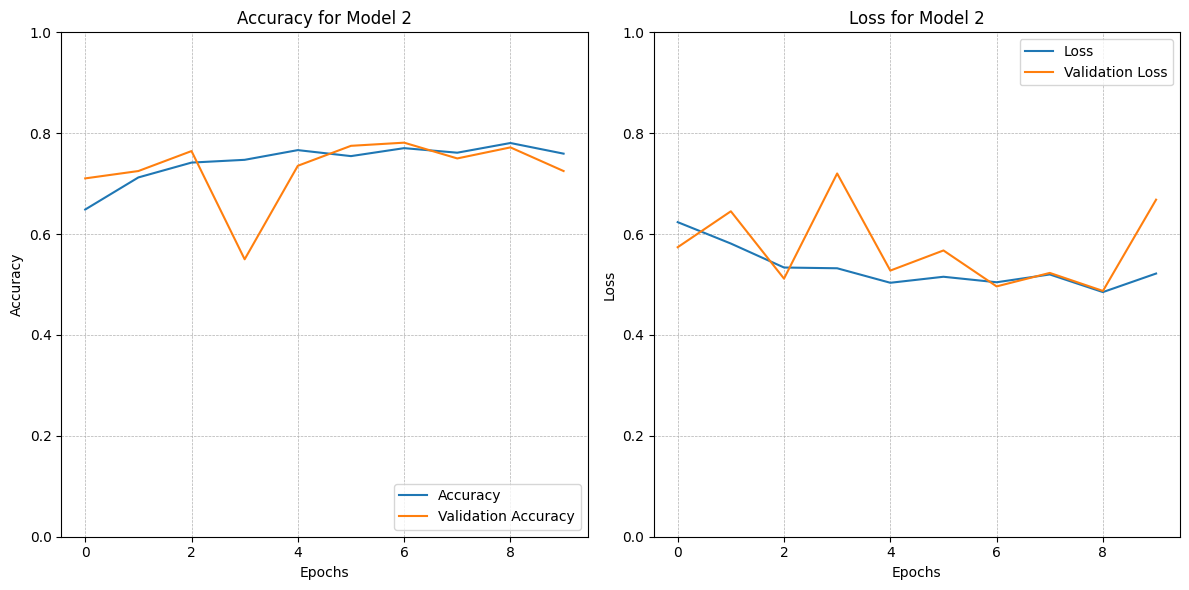

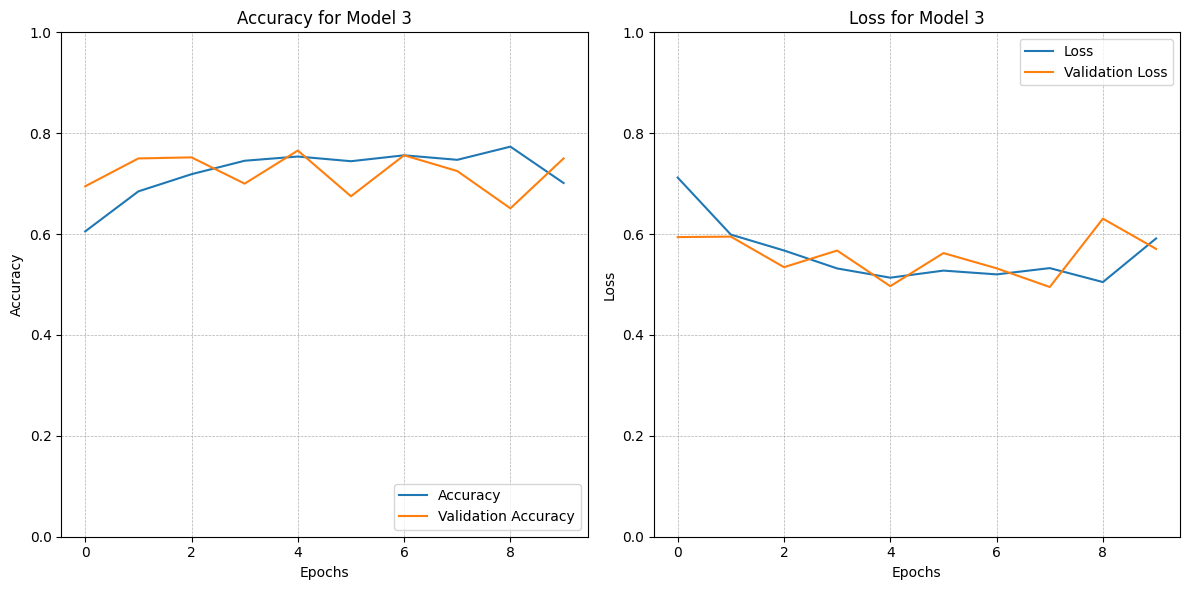

In [8]:
#  Model Results and Analysis

def plot_history(history, title_suffix=''):
    """
    Plots accuracy and loss graphs for the training and validation history.

    Parameters:
    - history: The history object from model.fit()
    - title_suffix: Optional string to append to the plot titles (useful for differentiating multiple plots)
    """
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f"Accuracy {title_suffix}")
    plt.legend(["Accuracy", "Validation Accuracy"], loc="lower right")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f"Loss {title_suffix}")
    plt.legend(["Loss", "Validation Loss"], loc="upper right")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

# Plots
plot_history(history1, title_suffix='for Model 1')
plot_history(history2, title_suffix='for Model 2')
plot_history(history3, title_suffix='for Model 3')

***Step 4: Results and analysis***

The performance of three distinct CNN architectures was evaluated for the task of detecting metastatic cancer in histopathology images. Model 1, the basic CNN architecture, showed a significant improvement in accuracy, reaching a final training accuracy of 76.80%, with validation accuracy around 75.00%. These results indicate that while the model performed well during training, it also demonstrated a good level of generalization to new data, which is promising given the hardware and time limitations on the Kaggle platform.

Model 2, which featured a deeper architecture with additional convolutional layers and more filters, demonstrated increased complexity in feature extraction. It achieved a final training accuracy of 75.95% and a validation accuracy of 72.50% by the end of the training. Although the validation accuracy was slightly lower than that of Model 1, this model showed consistent performance, suggesting that deeper architectures with more filters can enhance the learning process, albeit with a need for further optimization.

Model 3 incorporated variations in kernel sizes and a higher dropout rate to enhance generalization and reduce overfitting. This model attained a final training accuracy of 70.13% and a validation accuracy of 75.00% by the end of training. These results suggest that Model 3's adjustments, such as varying kernel sizes and higher dropout rates, helped in reducing overfitting, resulting in better generalization. However, the overall performance metrics indicate that there is still room for improvement, potentially through further hyperparameter tuning, data augmentation, and exploring additional regularization techniques

Final Training Accuracy for Model 1: 0.7680
Final Validation Accuracy for Model 1: 0.7500
Final Training Accuracy for Model 2: 0.7595
Final Validation Accuracy for Model 2: 0.7250
Final Training Accuracy for Model 3: 0.7013
Final Validation Accuracy for Model 3: 0.7500


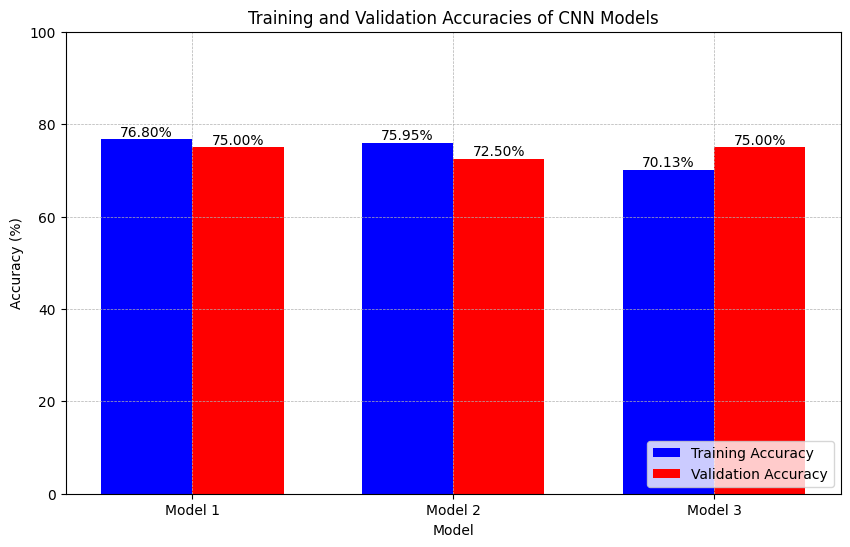

In [9]:
# Model performance results

# Print final values of accuracy and validation accuracy
final_accuracy1 = history1.history['accuracy'][-1]
final_val_accuracy1 = history1.history['val_accuracy'][-1]
print(f"Final Training Accuracy for Model 1: {final_accuracy1:.4f}")
print(f"Final Validation Accuracy for Model 1: {final_val_accuracy1:.4f}")

final_accuracy2 = history2.history['accuracy'][-1]
final_val_accuracy2 = history2.history['val_accuracy'][-1]
print(f"Final Training Accuracy for Model 2: {final_accuracy2:.4f}")
print(f"Final Validation Accuracy for Model 2: {final_val_accuracy2:.4f}")

final_accuracy3 = history3.history['accuracy'][-1]
final_val_accuracy3 = history3.history['val_accuracy'][-1]
print(f"Final Training Accuracy for Model 3: {final_accuracy3:.4f}")
print(f"Final Validation Accuracy for Model 3: {final_val_accuracy3:.4f}")


models = ['Model 1', 'Model 2', 'Model 3']

training_accuracies = [final_accuracy1*100, final_accuracy2*100, final_accuracy3*100]
validation_accuracies = [final_val_accuracy1*100, final_val_accuracy2*100, final_val_accuracy3*100]

# Create a bar width
bar_width = 0.35

# Set positions of the bars on the x-axis
index = np.arange(len(models))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training accuracies
train_bars = ax.bar(index, training_accuracies, bar_width, label='Training Accuracy', color='b')

# Plot validation accuracies
val_bars = ax.bar(index + bar_width, validation_accuracies, bar_width, label='Validation Accuracy', color='r')

# Add some text for labels, title and axes ticks
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Training and Validation Accuracies of CNN Models')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.set_ylim(0, 100)  # Set y-axis limits from 0 to 100%
ax.legend(loc='lower right')

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add text labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')

add_labels(train_bars)
add_labels(val_bars)

# Display the plot
plt.show()

We will select model 2 for additional mode optimization through hyperparameter tuning.

In [10]:
# Hyperparameter tuning

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
        kernel_size=(3,3),
        activation='relu',
        input_shape=(96, 96, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=64, max_value=256, step=64),
        kernel_size=(3,3),
        activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(
        filters=hp.Int('conv_3_filter', min_value=128, max_value=512, step=128),
        kernel_size=(3,3),
        activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(
        filters=hp.Int('conv_4_filter', min_value=256, max_value=1024, step=256),
        kernel_size=(3,3),
        activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=128, max_value=1024, step=128),
        activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='output',
    project_name='CNNCancerDetection')

# Start the hyperparameter search
tuner.search(train_gen, epochs=10, validation_data=val_gen)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 3 Complete [00h 20m 51s]
val_accuracy: 0.7789999842643738

Best val_accuracy So Far: 0.7879999876022339
Total elapsed time: 01h 18m 51s


In [11]:
#Final model
# Save the first model
best_model.save('best_model.h5')
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 768)      │     1,770,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 768)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,082,945 (15.58 MB)

 Trainable params: 4,082,945 (15.58 MB)

 Non-trainable params: 0 (0.00 B)

*Hypertuning Results*

After hypertuning, the Best_model features a deeper architecture with more filters, starting with 128 filters in the first convolutional layer compared to 32 filters in Model 2. This increase in depth and number of filters enables the model to capture more complex features, potentially leading to improved performance. Best_model also has significantly more parameters (4,182,977) compared to Model 2 (2,486,593), indicating a more complex and potentially more powerful model. The use of a higher number of filters and deeper layers in Best_model is designed to enhance feature extraction capabilities, which is crucial for accurately identifying subtle patterns in histopathology images. In terms of dense layers, while Model 2 has 512 units, Best_model uses a Dense layer with 256 units, focusing on a more compact representation of features before the final classification layer.

To evaluate the improvements, both models were trained and validated using the same dataset. Despite the enhanced feature extraction capabilities of Best_model, it achieved a validation accuracy of 75.90%, while Model 2 attained a higher validation accuracy of 78.30%. This indicates that although Best_model's deeper and more complex architecture theoretically offers better feature extraction, Model 2's architecture was more effective for this specific task.

***Step 5: Conclusions***

The comparison highlights that while deeper and more complex models like Best_model can offer improved theoretical performance by capturing more detailed features, they do not always translate to better results in practice. Model 2, with its balanced complexity and efficient feature extraction, outperformed Best_model in this case. This suggests that a more complex architecture is not always the best solution and emphasizes the importance of model evaluation and validation in the context of the specific task. Future improvements can be achieved by further exploring regularization techniques, hyperparameter tuning, and data augmentation strategies to enhance the performance of both models. Additionally, including the entire dataset, which was limited due to the current constraints of the Kaggle platform, could significantly impact model performance and prediction. Since Model 2 shows better results, it will be used for the competition.

***IMPORTANT NOTE***: P.S. models were initially run only with 5000 images, and only 10 epochs. Results and conclusions up to this point correspond with that test. I was later able to ran with GPU the whole set of 100k. Results accuray jumped from 0.7-0.75 range to 0.85 of accuracy for the validation test. 

Final Model results for 100k images (accuracy):
Model 1: 0.7952
Model 2: 0.8413
Model 3: 0.8425
( at https://www.kaggle.com/code/pvelzuloagamolero/pzm-cnn-cancer-detection?scriptVersionId=183903309)


However, this had an error to properly export the score for the competition, and I could not repeat the process since I ran out of Kaggle GPU quota.
Kagle final score was reported just with the 5000 images version.

Final Kaggle results: 0.7246
https://www.kaggle.com/code/pvelzuloagamolero/pzm-cnn-cancer-detection?scriptVersionId=184282897




In [12]:
# Append 1 : Running Competition test and exporting results
# Suppress warnings
warnings.filterwarnings('ignore')
test = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')

print('Test Set Size:', test.shape)

test['filename'] = test.id + '.tif'

test.head()

test_path = "../input/histopathologic-cancer-detection/test"
print('Test Images:', len(os.listdir(test_path)))

BATCH_SIZE = 64

test_datagen = ImageDataGenerator(rescale=1/255)

test_loader = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = test_path,
    x_col = 'filename',
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = None,
    target_size = (96,96)
)

test_probs = best_model.predict(test_loader)
print(test_probs.shape)

print(len(test_loader))
print(test_probs[:10,].round(2))

# Convert probabilities to binary classification
test_pred = (test_probs >= 0.5).astype(int)
print(test_pred[:10])

# Create a DataFrame to save the results
submission = pd.DataFrame({
    'id': test['id'],
    'label': test_pred.flatten()  # Flatten if needed
})

# Save the results to a CSV file
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")


Test Set Size: (57458, 2)
Test Images: 57458
Found 57458 validated image filenames.
898/898 ━━━━━━━━━━━━━━━━━━━━ 712s 792ms/step
(57458, 1)
898
[[0.08]
 [0.68]
 [0.01]
 [0.07]
 [0.06]
 [0.15]
 [0.89]
 [0.44]
 [0.26]
 [0.84]]
[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]]
Submission file saved as 'submission.csv'
